# Calculate heatwave duration within data

In [3]:
import iris
import pandas as pd
import xarray as xr
import numpy as np
from dask import array as da

In [4]:
def np_consecutive(arr):
    if isinstance(arr, (xr.DataArray, iris.cube.Cube)):
        data = arr.data
        if isinstance(data, da.Array):
            data.compute_chunk_sizes()
    else:
        data = arr
    out = np.diff(np.where(np.concatenate(([data[0]],
                                     data[:-1] != data[1:],
                                     [True])))[0])[::2]
    return out

In [5]:
def consec_count(data, threshold=25, ndays=14):
    
    days = np.arange(0, ndays+1)
    heatwave_counts = {}
    years = np.unique(data.year)
    for year in years:
        counts = np.zeros_like(days)
        arr = data[data.year==year]
        arr_hot = arr>threshold
        hots = np_consecutive(arr_hot)
        colds = np.count_nonzero(~arr_hot)
        counts[0]=colds
        for day in days[1:-1]:
            counts[day]=np.count_nonzero(hots==day)
        counts[-1]=np.count_nonzero(hots>=days[-1])

        heatwave_counts[year]=counts
    return heatwave_counts

In [6]:
def annual_heatwaves(data, **kwargs):
    if isinstance(data, iris.cube.Cube):
        data = xr.DataArray.from_iris(data).compute()
    ensemble = np.unique(data.ensemble_member)
    dfs = []
    for member in ensemble:
        arr = data.sel(ensemble_member=member).compute()
        counts = consec_count(arr, **kwargs)
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'year'}, inplace=True)
        df['ensemble_member']=member
        dfs.append(df)
    return pd.concat(dfs)

## `tasmax`

In [7]:
%%time
fname = "data/UKCP/utci_regional/tasmax_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
tasmax = iris.load_cube(fname)
tasmax.summary(shorten=True)

CPU times: user 331 ms, sys: 27.7 ms, total: 358 ms
Wall time: 831 ms


'air_temperature / (degC)            (ensemble_member: 12; time: 21600)'

### Annual hot days (number of days above 28°C)

In [8]:
%%time
tashot = tasmax.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>=28)
tashot.rename("Annual Hot Days")

CPU times: user 1.14 s, sys: 58.7 ms, total: 1.2 s
Wall time: 1.32 s


### Annual heatwave days (number of days within a heatwave | 3+ days of >28°C)

In [9]:
%%time
tashw = (annual_heatwaves(tasmax, threshold=28, ndays=90)
         .drop(columns=[0, 1, 2])
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(heatwave_days=lambda df: df.duration*df.occurances)
         .drop(columns=['duration', 'occurances'])
         .groupby(['year', 'ensemble_member'])
         .sum()
         .reset_index()
        )
tashw.head()

CPU times: user 2.19 s, sys: 41.4 ms, total: 2.23 s
Wall time: 2.35 s


,year,ensemble_member,heatwave_days
0,1980,1,0
1,1980,4,0
2,1980,5,0
3,1980,6,0
4,1980,7,0


## `utci`

In [10]:
%%time
fname = "data/UKCP/utci_regional/utcimax_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
utci = iris.load_cube(fname)
utci.summary(shorten=True)

CPU times: user 230 ms, sys: 16.5 ms, total: 246 ms
Wall time: 341 ms


'utci / (degC)                       (ensemble_member: 12; time: 21600)'

### Annual hot days (number of days above 28°C)

In [11]:
%%time
utcihot = utci.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>=28)
utcihot.rename("Annual Hot Days (UTCI)")

CPU times: user 1.02 s, sys: 28.8 ms, total: 1.05 s
Wall time: 1.11 s


### Annual heatwave days (number of days within a heatwave | 3+ days of >28°C)

In [12]:
%%time
utcihw = (annual_heatwaves(utci, threshold=28, ndays=90)
         .drop(columns=[0, 1, 2])
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(heatwave_days=lambda df: df.duration*df.occurances)
         .drop(columns=['duration', 'occurances'])
         .groupby(['year', 'ensemble_member'])
         .sum()
         .reset_index()
        )
utcihw.head()

CPU times: user 2.3 s, sys: 46 ms, total: 2.35 s
Wall time: 2.5 s


,year,ensemble_member,heatwave_days
0,1980,1,0
1,1980,4,0
2,1980,5,0
3,1980,6,0
4,1980,7,0


## `utci10`

In [13]:
%%time
fname = "data/UKCP/utci_regional/utci10max_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
u10 = iris.load_cube(fname)
u10.summary(shorten=True)

CPU times: user 274 ms, sys: 19 ms, total: 293 ms
Wall time: 350 ms


'utci class 10 / (1)                 (ensemble_member: 12; time: 21600)'

### Annual hot days (number of days above 28°C)

In [14]:
%%time
u10hot = u10.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>6.0)
u10hot.rename("Annual Heatstress Days (UTCI10)")

CPU times: user 1.08 s, sys: 32.1 ms, total: 1.11 s
Wall time: 1.18 s


### Annual heatwave days (number of days within a heatwave | 3+ days of >28°C)

In [15]:
%%time
u10hw = (annual_heatwaves(u10, threshold=6.0, ndays=90)
         .drop(columns=[0, 1, 2])
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(heatwave_days=lambda df: df.duration*df.occurances)
         .drop(columns=['duration', 'occurances'])
         .groupby(['year', 'ensemble_member'])
         .sum()
         .reset_index()
        )
u10hw.head()

CPU times: user 2.2 s, sys: 40.3 ms, total: 2.24 s
Wall time: 2.3 s


,year,ensemble_member,heatwave_days
0,1980,1,0
1,1980,4,0
2,1980,5,0
3,1980,6,0
4,1980,7,0


# Boxplots

In [29]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [17]:
def decadal_hot_counts(cube, years):
    xss = []
    ls = []
    for d in years:
        xs = []
        for y in range(d+1, d+11):
            x=cube.extract(iris.Constraint(year=y)).data
            xs.extend(x)
        xss.append(xs)
        ls.append(f"{d}s")
    return xss, ls


def decadal_hw_counts(df, years):
    xss = []
    ls = []
    for d in years:
        xs = []
        for y in range(d+1, d+11):
            x=df[df.year==y].heatwave_days
            xs.extend(x)
        xss.append(xs)
        ls.append(f"{d}s")
    return xss, ls

In [170]:
def boxplot_ax(xss, ls, ax=None, title="", ylim=120, boxcolor='deepskyblue'):
    if ax == None:
        ax = plt.axes()
    ax.boxplot(xss, labels=ls,
              patch_artist=True,
              boxprops={'facecolor': boxcolor},
              medianprops={'color': '#1536E2'},
              flierprops={'marker': 'o', 'markerfacecolor': boxcolor})
    ax.set_title(title, y=0.88)
#     ax.set_xlabel("Decade")
#     ax.set_ylabel("Number of days per year")
    ax.set_ylim((0,ylim))
    ax.grid(axis='y')
    ax.set_axisbelow(True)

def box_decadal(data, years, **pltkwargs):
    if isinstance(data, iris.cube.Cube):
        xss, ls = decadal_hot_counts(data, years)
    elif isinstance(data, pd.DataFrame):
        xss, ls = decadal_hw_counts(data, years)
    else:
        raise TypeError
    
    boxplot_ax(xss, ls, **pltkwargs)

CPU times: user 2.92 s, sys: 113 ms, total: 3.03 s
Wall time: 3.1 s


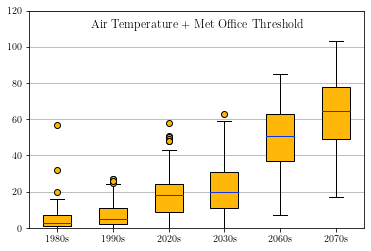

In [120]:
%%time
years = (1980, 1990, 2020, 2030, 2060, 2070)
box_decadal(tashot, years, title='Air Temperature + Met Office Threshold')

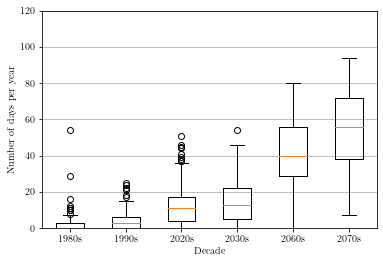

In [38]:
box_decadal(tashw, years)

In [174]:
def mega_boxplot(datas, subtitles, fname, title, boxcolors):
    years = (1980, 1990, 2020, 2030, 2060, 2070)
    
    width=8.50166
    fsize=(width, 3*width/2.5)

    fig, axs = plt.subplots(3,2, sharex=False, sharey=False, figsize=fsize)

    fig.suptitle(title, x=0.1, y=0.93, ha='left', fontsize='x-large')
    fig.text(0.30, 0.895, 'Hot Days', ha='center', va='center', fontsize='large')
    fig.text(0.73, 0.895, 'Heatwave Days', ha='center', va='center', fontsize='large')
    fig.text(0.51, 0.09, 'Decade', ha='center', va='center')
    fig.text(0.07, 0.5, 'Number of days per year', ha='center', va='center', rotation='vertical')

    for i in range(6):
        ax = axs.flatten()[i]
        data = datas[i]
        subtitle = subtitles[i]
        boxcolor = boxcolors[i]
        box_decadal(data, years, ax=ax, title=subtitle, boxcolor=boxcolor)
    
#     plt.show()
    plt.savefig(f"pngs/{fname}.png", bbox_inches='tight')
    plt.savefig(f"pdfs/{fname}.pdf", bbox_inches='tight')
    plt.savefig(f"pgfs/{fname}.pgf", bbox_inches='tight')

In [175]:
datas = [tashot, tashw, utcihot, utcihw, u10hot, u10hw]
subtitles = ['Air Temperature + Met Office Threshold', 'Air Temperature + Met Office Threshold', 
             'UTCI + Met Office Threshold', 'UTCI + Met Office Threshold', 
             'UTCI + Heat Stress Threshold', 'UTCI + Heat Stress Threshold']
boxcolors = ['#DD7F22', '#E14C1E']*3
fname='boxplots'
title='Decadal comparison of annual number of hot and heatwave days'

CPU times: user 11.2 s, sys: 389 ms, total: 11.6 s
Wall time: 13.8 s


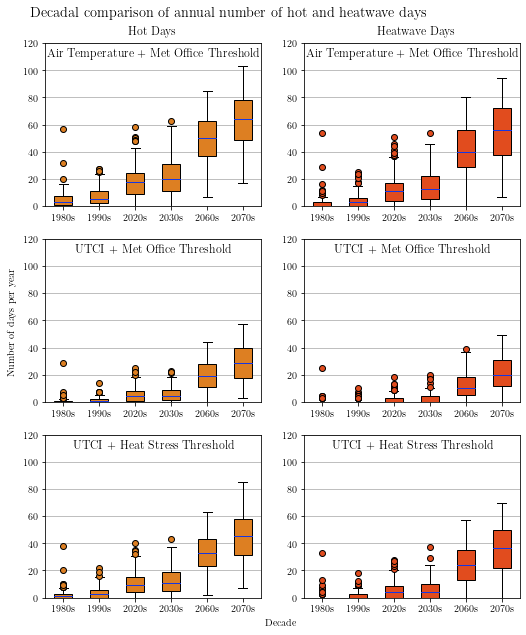

In [176]:
%%time
mega_boxplot(datas, subtitles, fname, title, boxcolors)